### Import

In [33]:
if (!requireNamespace("BiocManager")) install.packages("BiocManager")
BiocManager::install(c("clusterProfiler", "DOSE", "GOplot", "enrichplot", "org.Mm.eg.db"))

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Warning message:
"package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'clusterProfiler' 'DOSE' 'GOplot' 'enrichplot' 'org.Mm.eg.db'"
Installation paths not writeable, unable to update packages
  path: C:/Program Files/R/R-4.1.2/library
  packages:
    cli, clipr, colorspace, crayon, evaluate, future, GenomeInfoDb, limma,
    metap, RCurl, Rdpack, recipes, RSQLite, scattermore, seriation,
    spatstat.core, spatstat.geom, tidyselect, tidytree, tinytex, TSP

Old packages: 'yaml'



In [1]:
.libPaths(c("C:/Program Files/R/R-4.1.2/library", .libPaths()))
install.packages("devtools")
devtools::install_github("GuangchuangYu/clusterProfiler")

Installing package into 'C:/Program Files/R/R-4.1.2/library'
(as 'lib' is unspecified)



package 'devtools' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\shaoq\AppData\Local\Temp\RtmpeyB4yv\downloaded_packages


GenomeInfoDb (1.30.0 -> 1.30.1) [CRAN]


Installing 1 packages: GenomeInfoDb

Installing package into 'C:/Program Files/R/R-4.1.2/library'
(as 'lib' is unspecified)



package 'GenomeInfoDb' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\shaoq\AppData\Local\Temp\RtmpeyB4yv\downloaded_packages
v  checking for file 'C:\Users\shaoq\AppData\Local\Temp\RtmpeyB4yv\remotes14e0505a30b4\YuLab-SMU-clusterProfiler-9659d59/DESCRIPTION'
-  preparing 'clusterProfiler': (719ms)
v  checking DESCRIPTION meta-information
-  checking for LF line-endings in source and make files and shell scripts
-  checking for empty or unneeded directories
-  looking to see if a 'data/datalist' file should be added
-  building 'clusterProfiler_4.3.2.991.tar.gz'
   


Installing package into 'C:/Program Files/R/R-4.1.2/library'
(as 'lib' is unspecified)



In [2]:
install.packages(c("ggnewscale", "ggridges", "ggupset", "here"))

Installing packages into 'C:/Program Files/R/R-4.1.2/library'
(as 'lib' is unspecified)



package 'ggnewscale' successfully unpacked and MD5 sums checked
package 'ggridges' successfully unpacked and MD5 sums checked
package 'ggupset' successfully unpacked and MD5 sums checked
package 'here' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\shaoq\AppData\Local\Temp\RtmpeyB4yv\downloaded_packages


In [7]:
library(clusterProfiler)
library(DOSE)
library(enrichplot)
library(ggnewscale)
library(ggplot2)
library(ggupset)
library(GOplot)
library(here)
library(org.Mm.eg.db)
library(tidyverse)

Loading required package: ggdendro

Loading required package: gridExtra

Loading required package: RColorBrewer

here() starts at C:/Users/shaoq/OneDrive/PythonScripts/Experiment Project/HHP RNA-seq

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welco

## Read data

In [9]:
filename <- here()
# d <- read_csv(here(filename, 'output/forGO_all_new.csv'))
d <- read_csv(here(filename, "output/", "forGO_all_new_KO.csv"))
colnames(d) <- c("SYMBOL", "LogFC")
head(d)
dim(d)

Rows: 1433 Columns: 2
-- Column specification -------------------------------------------------------------------------------------------------------------------------------------------------------
Delimiter: ","
chr (1): SYMBOL
dbl (1): logFC

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


SYMBOL,LogFC
<chr>,<dbl>
Cd44,-7.531744
Krt17,-5.839735
Krt14,-5.291122
Krt5,-4.906016
Bc1,-3.558162
ATP8,-3.250248


[1] 1433    2

## Get ENTREZID

In [10]:
# find entrzid for each gene
ids <- mapIds(org.Mm.eg.db, keys = d$SYMBOL, keytype = "SYMBOL", column = "ENTREZID", fuzzy = TRUE,
    multiVals = "first")
length(ids)
head(ids)

'select()' returned 1:1 mapping between keys and columns



[1] 1433

Cd44       Krt17       Krt14        Krt5         Bc1        ATP8 
    "12505"     "16667"     "16664"    "110308" "100568459"     "17706"

In [11]:
d$ENTREZID <- as.character(ids)
d <- d %>%
    arrange(ENTREZID)
head(d)

SYMBOL,LogFC,ENTREZID
<chr>,<dbl>,<chr>
Gm10516,-0.7192922,100038712
Gm14295,-0.7563502,100039123
Dynlt1f,0.8224176,100040531
Mirg,-1.2671299,100040724
Gm3587,-1.6852384,100041951
Oaz1-ps,1.1462665,100041965


## enrichGo analysis

In [12]:
# enrichGo analysis for BP, MF, CC catafories
ego_bp <- enrichGO(gene = d$ENTREZID, OrgDb = "org.Mm.eg.db", keyType = "ENTREZID",
    ont = "BP", pvalueCutoff = 0.05, pAdjustMethod = "BH", qvalueCutoff = 0.05, minGSSize = 10,
    maxGSSize = 500, readable = TRUE, pool = FALSE)
ego_mf <- enrichGO(gene = d$ENTREZID, OrgDb = "org.Mm.eg.db", keyType = "ENTREZID",
    ont = "MF", pvalueCutoff = 0.05, pAdjustMethod = "BH", qvalueCutoff = 0.05, minGSSize = 10,
    maxGSSize = 500, readable = TRUE, pool = FALSE)
ego_cc <- enrichGO(gene = d$ENTREZID, OrgDb = "org.Mm.eg.db", keyType = "ENTREZID",
    ont = "CC", pvalueCutoff = 0.05, pAdjustMethod = "BH", qvalueCutoff = 0.05, minGSSize = 10,
    maxGSSize = 500, readable = TRUE, pool = FALSE)

In [13]:
summary(ego_mf)

Warning message in summary(ego_mf):
"summary method to convert the object to data.frame is deprecated, please use as.data.frame instead."


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015453,GO:0015453,oxidoreduction-driven active transmembrane transporter activity,22/1277,50/28438,4.995917e-17,4.881011e-14,4.007252e-14,Cox4i1/Cox5a/Cox6c/Cox7a2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Uqcrq/Cyb561a3/Cyb561d2/Ndufa7/Cyc1/Uqcrfs1/Cox4i2,22
GO:0015399,GO:0015399,primary active transmembrane transporter activity,34/1277,169/28438,1.508528e-13,7.369160e-11,6.049992e-11,Atp6v1h/Atp6v0b/Atp6v0c/Cox4i1/Cox5a/Cox6c/Cox7a2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Slc4a2/Tap2/Uqcrq/Cyb561a3/Clcn7/Atp5l/Abcb10/Cyb561d2/Atp6v1f/Atp6v1g2/Ndufa7/Cyc1/Uqcrfs1/Atp5e/Abcb8/Cox4i2,34
GO:0022804,GO:0022804,active transmembrane transporter activity,54/1277,396/28438,3.803250e-13,9.537386e-11,7.830079e-11,Slc15a4/Slc6a8/Slc35e4/Atp6v1h/Atp6v0b/Slc25a5/Atp6v0c/Cox4i1/Cox5a/Cox6c/Cox7a2/Slc17a6/Slc37a4/Slc8b1/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Slc25a3/Slc12a3/Slc12a4/Slc12a7/Slc1a5/Slc4a2/Slc8a1/Tap2/Uqcrq/Cyb561a3/Slc5a11/Clcn7/Slc25a10/Atp5l/Slc2a8/Abcb10/Cyb561d2/Slc37a2/Atp6v1f/Atp6v1g2/Ndufa7/Cyc1/Uqcrfs1/Atp5e/Slc25a11/Mfsd12/Abcb8/Slc12a9/Cox4i2,54
GO:0015078,GO:0015078,proton transmembrane transporter activity,27/1277,111/28438,4.038840e-13,9.537386e-11,7.830079e-11,Slc15a4/Atp6v1h/Atp6v0b/Slc25a5/Atp5k/Atp6v0c/Cox4i1/Cox5a/Cox6c/Cox7a2/ATP6/ATP8/COX2/COX3/CYTB/Uqcrq/Atp5g3/Atp5l/Atp5o/Atp6v1f/Atp6v1g2/Cyc1/Uqcrfs1/Atp5e/Atp5g2/Hvcn1/Cox4i2,27
GO:0003735,GO:0003735,structural constituent of ribosome,33/1277,166/28438,4.880955e-13,9.537386e-11,7.830079e-11,Rplp0/Rpl19/Rpl21/Rpl37a/Rpl9/Rps14/Rps19/Rps29/Rps4x/Rps5/Rps8/Rpl13/Rps3/Rpl36/Rplp1/Rps27/Rpl35a/Mrps14/Ndufa7/Rps21/Mrpl33/Rpl14/Rplp2/Rpl39/Rps20/Mrps11/Rpl22l1/Rps13/Mrpl14/Mrps18a/Mrpl28/Mrpl32/Mrps5,33
GO:0009055,GO:0009055,electron transfer activity,21/1277,70/28438,1.993433e-12,3.245973e-10,2.664905e-10,Cox4i1/Cox5a/Cox6c/Cox7a2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Uqcrq/Sdhc/Ndufa7/Cyc1/Uqcrfs1/Cox4i2,21
GO:0003954,GO:0003954,NADH dehydrogenase activity,10/1277,25/28438,5.673349e-08,7.918374e-06,6.500890e-06,ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Enox1/Ndufa7,10
GO:0022853,GO:0022853,active ion transmembrane transporter activity,32/1277,246/28438,7.171379e-08,8.758047e-06,7.190251e-06,Slc15a4/Slc6a8/Atp6v1h/Atp6v0b/Slc25a5/Atp6v0c/Cox4i1/Cox5a/Cox6c/Cox7a2/Slc37a4/Slc8b1/COX2/COX3/CYTB/Slc12a3/Slc12a4/Slc12a7/Slc4a2/Slc8a1/Uqcrq/Slc5a11/Clcn7/Atp5l/Slc37a2/Atp6v1f/Atp6v1g2/Cyc1/Uqcrfs1/Atp5e/Slc12a9/Cox4i2,32
GO:0008137,GO:0008137,NADH dehydrogenase (ubiquinone) activity,9/1277,22/28438,2.112939e-07,2.064341e-05,1.694799e-05,ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Ndufa7,9


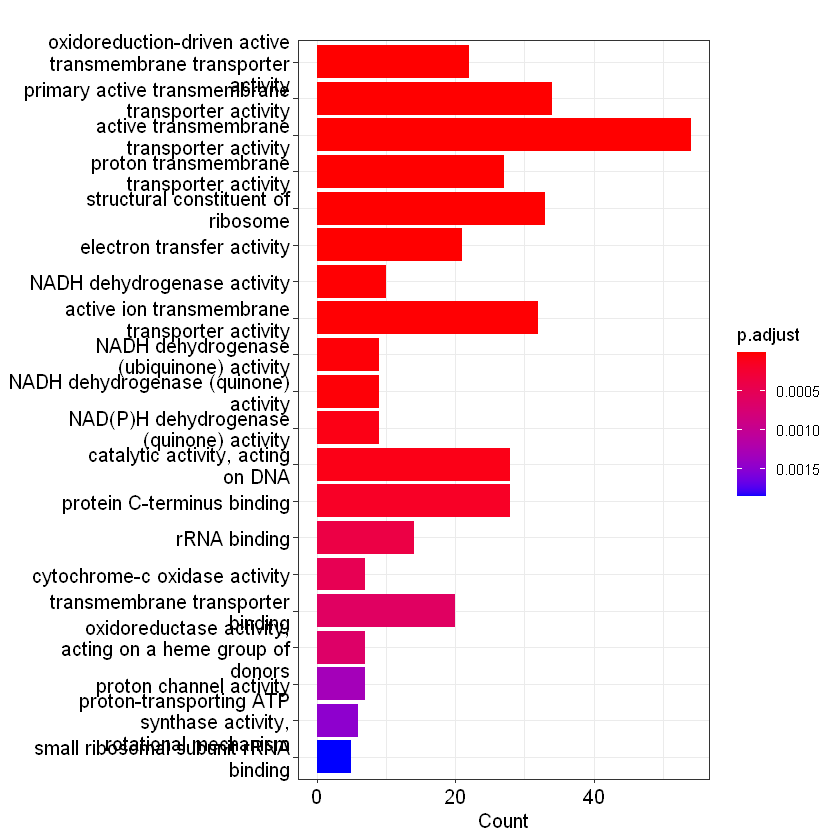

In [14]:
# test the barplot
barplot(ego_mf, showCategory=20)

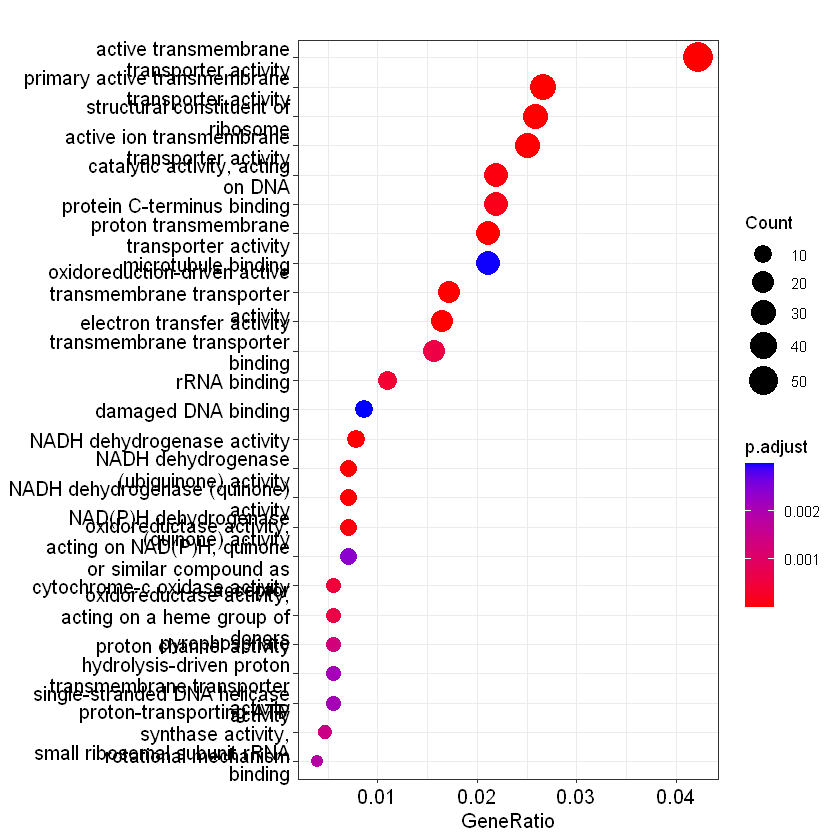

In [15]:
dotplot(ego_mf, showCategory = 25, label_format = 30)

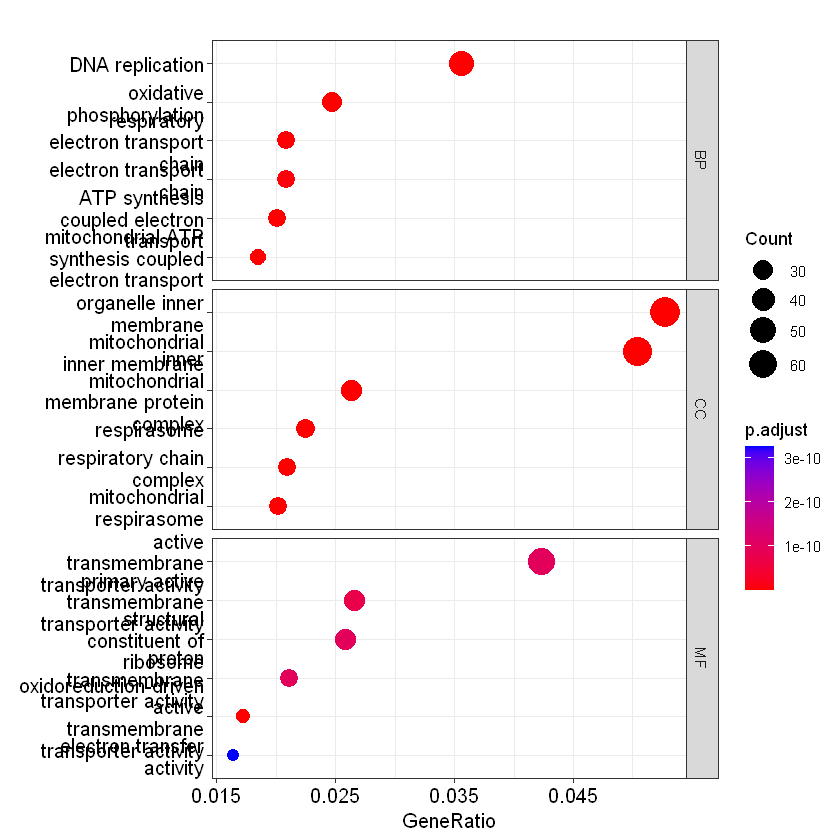

In [16]:
# plot 3 catergories in one dotplot
go <- enrichGO(d$ENTREZID, OrgDb = "org.Mm.eg.db", ont = "all",
pvalueCutoff = 0.05, pAdjustMethod = "fdr", qvalueCutoff = 0.05)
dotplot(go, split = "ONTOLOGY", showCategory = 6, label_format = 20) + facet_grid(ONTOLOGY ~
    ., scale = "free")

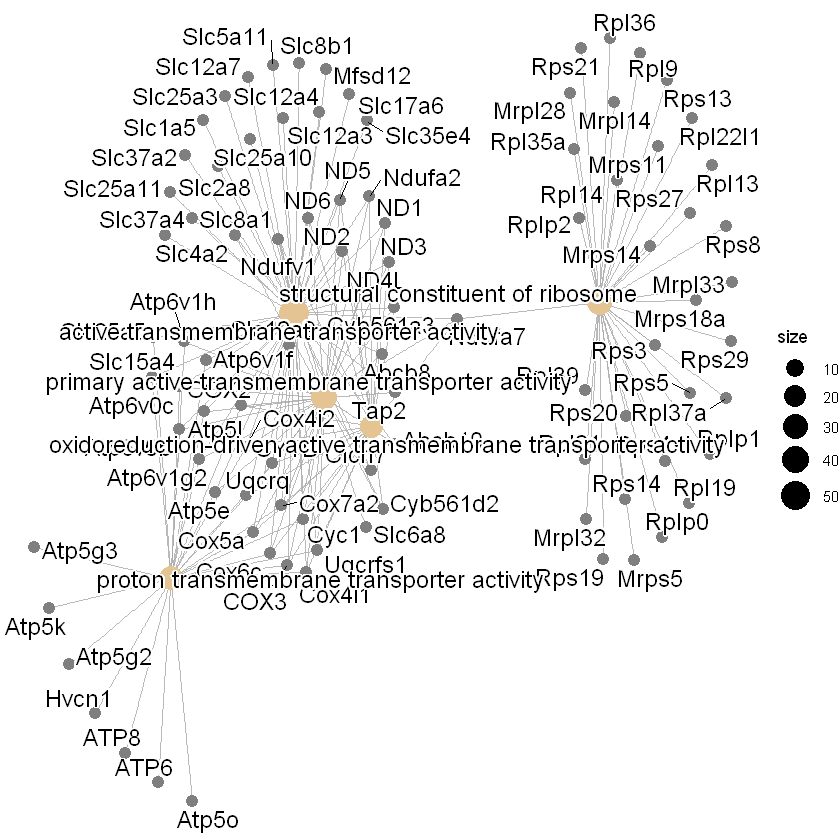

In [17]:
## remove redundent GO terms
cnetplot(ego_mf, foldChange=d$LogFC)

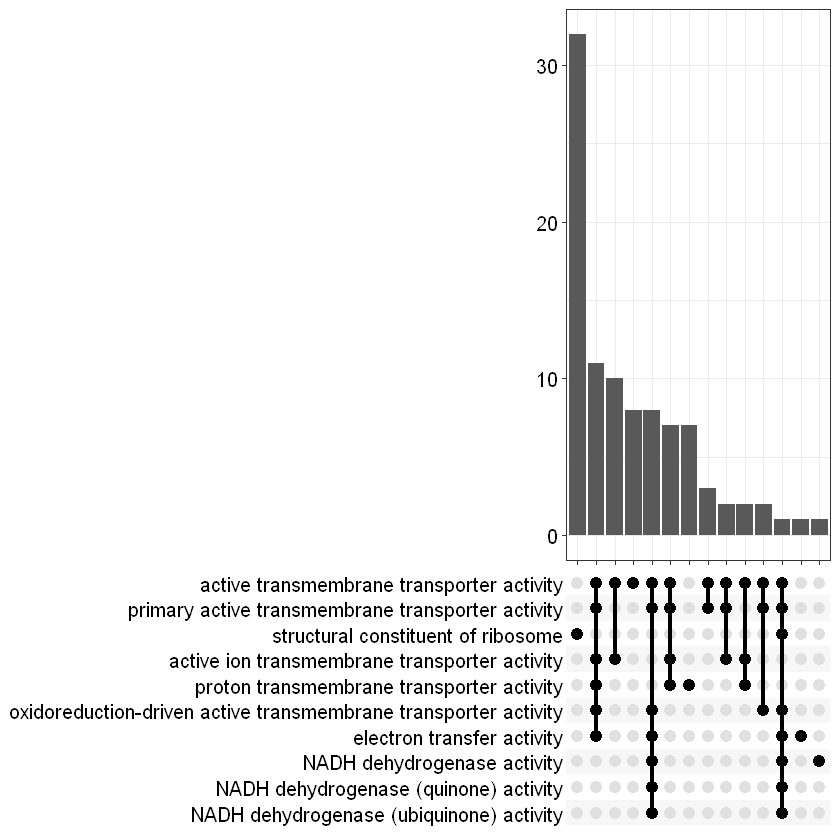

In [18]:
# upset plot
upsetplot(ego_mf)

In [19]:
# KEGG go analysis with enrichKEGG
edo2 <- enrichKEGG(d$ENTREZID, organism = "mmu",  minGSSize = 120, pvalueCutoff = 0.05)

Reading KEGG annotation online:


Reading KEGG annotation online:




In [20]:
summary(edo2)

Warning message in summary(edo2):
"summary method to convert the object to data.frame is deprecated, please use as.data.frame instead."


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
mmu00190,mmu00190,Oxidative phosphorylation,44/577,135/8948,2.590093e-20,2.615994e-18,2.126603e-18,104130/108664/114143/11958/11984/12857/12858/12864/12866/17705/17706/17709/17710/17711/17716/17717/17718/17720/17721/17722/17991/17992/17995/22272/228033/230075/27060/27425/28080/66052/66144/66152/66237/66377/66414/66416/66445/66694/66925/67126/67530/67942/69875/84682,44
mmu05012,mmu05012,Parkinson disease,50/577,264/8948,2.603239e-12,1.099862e-10,8.941036e-11,104130/106947/11740/11783/12322/12857/12858/12864/12866/14680/14977/17705/17706/17709/17710/17711/17716/17717/17718/17720/17721/17722/17991/17992/17995/19172/19173/22143/22146/22190/22272/228033/230075/26446/28080/66052/66152/66377/66414/66416/66445/66694/66925/67126/67530/67942/67951/69806/69875/84682,50
mmu04714,mmu04714,Thermogenesis,46/577,231/8948,3.266917e-12,1.099862e-10,8.941036e-11,104130/11513/11958/12857/12858/12864/12866/14182/17705/17706/17709/17710/17711/17716/17717/17718/17720/17721/17722/17991/17992/17995/20587/22272/228033/230075/271639/27425/28080/66052/66152/66377/66379/66414/66416/66445/66694/66706/66925/67126/67530/67942/68033/69875/72508/84682,46
mmu05208,mmu05208,Chemical carcinogenesis - reactive oxygen species,44/577,222/8948,1.168024e-11,2.949261e-10,2.397523e-10,103140/104130/11740/12857/12858/12864/12866/15234/17295/17705/17706/17709/17710/17711/17716/17717/17718/17720/17721/17722/17991/17992/17995/18709/20779/22272/228033/230075/26396/28080/58810/66052/66152/66377/66414/66416/66445/66694/66925/67126/67530/67942/69875/84682,44
mmu05415,mmu05415,Diabetic cardiomyopathy,42/577,211/8948,3.024882e-11,6.110261e-10,4.967174e-10,104130/110854/11740/12322/12857/12858/12864/12866/17390/17705/17706/17709/17710/17711/17716/17717/17718/17720/17721/17722/17991/17992/17995/18709/22272/228033/230075/28080/66052/66152/66377/66414/66416/66445/66694/66925/67126/67530/67942/69875/70456/84682,42
mmu05016,mmu05016,Huntington disease,52/577,302/8948,4.067641e-11,6.847195e-10,5.566245e-10,104130/11740/11771/11783/12064/12857/12858/12864/12866/14778/14802/17705/17706/17709/17710/17711/17716/17717/17718/17720/17721/17722/17991/17992/17995/19172/19173/21374/22143/22146/22272/228033/230075/232910/26446/28080/66052/66152/66377/66414/66416/66445/66694/66925/67126/67305/67530/67942/67951/69241/69875/84682,52
mmu05010,mmu05010,Alzheimer disease,60/577,383/8948,6.839210e-11,9.868003e-10,8.021931e-10,104130/106947/11740/11783/11789/12387/12857/12858/12864/12866/13543/14362/14368/14369/14977/15925/16971/17705/17706/17709/17710/17711/17716/17717/17718/17720/17721/17722/17991/17992/17995/18709/19055/19172/19173/22143/22146/22272/22413/226548/228033/230075/26396/26446/28080/66052/66152/66377/66414/66416/66445/66694/66925/67126/67530/67942/67951/69806/69875/84682,60
mmu05020,mmu05020,Prion disease,47/577,268/8948,1.954098e-10,2.467049e-09,2.005522e-09,104130/11740/11783/12857/12858/12864/12866/13653/17705/17706/17709/17710/17711/17716/17717/17718/17720/17721/17722/17991/17992/17995/18709/19055/19172/19173/22143/22146/22272/228033/230075/26446/28080/66052/66152/66377/66414/66416/66445/66694/66925/67126/67530/67942/67951/69875/84682,47
mmu05014,mmu05014,Amyotrophic lateral sclerosis,57/577,369/8948,3.713320e-10,4.167170e-09,3.387590e-09,100042150/104130/11744/11783/12460/12857/12858/12864/12866/14778/17705/17706/17709/17710/17711/17716/17717/17718/17720/17721/17722/17991/17992/17995/18183/19055/19172/19173/20239/211323/21353/22143/22146/22272/228033/230075/233908/26446/28080/56488/66052/66152/66377/66414/66416/66445/66694/66925/67126/67305/67530/67819/67942/67951/69736/69875/84682,57


## New dotplot

In [21]:
# draw better dotplot with ggplot transform go analysis data to dataframe
bp_go_df <- as_tibble(ego_bp)
cc_go_df <- as_tibble(ego_cc)
mf_go_df <- as_tibble(ego_mf)
head(bp_go_df)
dim(bp_go_df)
head(cc_go_df)
dim(cc_go_df)
head(mf_go_df)
dim(mf_go_df)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0042773,ATP synthesis coupled electron transport,26/1294,67/29008,2.791353e-18,1.491420e-14,1.204983e-14,Bdnf/Cdk1/Cox4i1/Cox5a/Chchd2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufv1/Uqcrq/Ndufb6/Ccnb1/Sdhc/Uqcr10/Ndufa12/Ndufa7/Cyc1/Sdhd/Uqcrb/Cox4i2,26
GO:0006119,oxidative phosphorylation,32/1294,113/29008,1.856640e-17,4.960013e-14,4.007410e-14,Atp5k/Bdnf/Cdk1/Cox4i1/Cox5a/Cox7a2/Chchd2/ATP6/ATP8/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufv1/Uqcrq/Ndufb6/Ccnb1/Atp5o/Sdhc/Uqcr10/Ndufa12/Ndufa7/Cyc1/Sdhd/Atp5e/Uqcrb/Cox4i2,32
GO:0042775,mitochondrial ATP synthesis coupled electron transport,24/1294,65/29008,2.145577e-16,3.821272e-13,3.087372e-13,Bdnf/Cdk1/Cox4i1/Cox5a/Chchd2/COX3/CYTB/ND1/ND2/ND3/ND5/ND6/Ndufv1/Uqcrq/Ndufb6/Ccnb1/Sdhc/Uqcr10/Ndufa12/Ndufa7/Cyc1/Sdhd/Uqcrb/Cox4i2,24
GO:0006260,DNA replication,46/1294,253/29008,3.698967e-16,4.940896e-13,3.991964e-13,Rfc4/Ccdc88a/Ehmt2/Cdk1/Fen1/Fgfr1/Id3/Inppl1/Lig1/Mcm3/Mcm2/Mcm6/Mcm7/Met/Pcna/Pold1/Polg/Rbbp4/Rbbp6/Rfc2/Rny3/Rpa2/Rrm1/Rrm2/Gen1/Mms22l/Chtf18/Dnajc2/Chaf1a/Gins2/Bcar3/Tspyl2/Poll/Gmnn/Repin1/Donson/Bod1l/Cdt1/Rpa1/Ciz1/Cdan1/Pold4/Mcm10/Tonsl/Ticrr/Polh,46
GO:0022904,respiratory electron transport chain,27/1294,87/29008,4.635573e-16,4.953573e-13,4.002207e-13,Bdnf/Cdk1/Cox4i1/Cox5a/Chchd2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufv1/Uqcrq/Ndufb6/Ccnb1/Slc37a2/Sdhc/Uqcr10/Ndufa12/Ndufa7/Cyc1/Sdhd/Uqcrb/Cox4i2,27
GO:0022900,electron transport chain,27/1294,95/29008,5.404212e-15,4.812451e-12,3.888188e-12,Bdnf/Cdk1/Cox4i1/Cox5a/Chchd2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufv1/Uqcrq/Ndufb6/Ccnb1/Slc37a2/Sdhc/Uqcr10/Ndufa12/Ndufa7/Cyc1/Sdhd/Uqcrb/Cox4i2,27


[1] 504   9

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0070469,respirasome,29/1290,92/28886,2.434326e-17,9.095073e-15,5.904323e-15,Ndufb11/Cox4i1/Cox5a/Cox7a2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufa4/Ndufv1/Uqcrq/Ndufb6/Sdhc/Uqcr10/Ndufc1/Ndufa12/Ndufa7/Cyc1/Uqcrfs1/Sdhd/Uqcrb/Ndufa11/Cox4i2,29
GO:0098800,inner mitochondrial membrane protein complex,34/1290,130/28886,2.869108e-17,9.095073e-15,5.904323e-15,Ndufb11/Atp5k/Cox4i1/Cox5a/ATP6/ATP8/CYTB/ND1/ND2/ND3/ND4L/ND5/Ndufa2/Ndufa4/Ndufv1/Uqcrq/Atp5g3/Ndufb6/Atp5l/Atp5o/Sdhc/Uqcr10/Ndufc1/Ndufa12/Ndufa7/Cyc1/Timm50/Uqcrfs1/Sdhd/Atp5e/Uqcrb/Atp5g2/Ndufa11/Cox4i2,34
GO:0098803,respiratory chain complex,27/1290,82/28886,8.726407e-17,1.844181e-14,1.197202e-14,Ndufb11/Cox4i1/Cox5a/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/Ndufa2/Ndufa4/Ndufv1/Uqcrq/Ndufb6/Sdhc/Uqcr10/Ndufc1/Ndufa12/Ndufa7/Cyc1/Uqcrfs1/Sdhd/Uqcrb/Ndufa11/Cox4i2,27
GO:0005743,mitochondrial inner membrane,65/1290,456/28886,1.271552e-16,2.015409e-14,1.308360e-14,Ndufb11/Slc25a5/Atp5k/Bdnf/Cox4i1/Cox5a/Cox6c/Cox7a2/Fdxr/Hmgcl/Lgals3/Slc8b1/ATP6/ATP8/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufa4/Ndufv1/Nnt/Slc25a15/Slc25a3/Polg/Src/Tst/Uqcrq/Atp5g3/Ndufb6/Mpst/Gcat/Gcdh/Rps3/Slc25a10/Atp5l/Atp5o/Abcb10/Gpx4/Sdhc/Uqcr10/Tmem14c/Ndufc1/Ndufa12/Ndufa7/Cyc1/Timm50/Uqcrfs1/Ndufaf3/Sdhd/Atp5e/Uqcrb/Slc25a11/Atp5g2/Ndufa11/Mpc2/Adck1/Spns1/Abcb8/Cox4i2,65
GO:0005746,mitochondrial respirasome,26/1290,77/28886,1.600215e-16,2.029073e-14,1.317230e-14,Ndufb11/Cox4i1/Cox5a/Cox7a2/CYTB/ND1/ND2/ND3/ND4L/ND5/Ndufa2/Ndufa4/Ndufv1/Uqcrq/Ndufb6/Sdhc/Uqcr10/Ndufc1/Ndufa12/Ndufa7/Cyc1/Uqcrfs1/Sdhd/Uqcrb/Ndufa11/Cox4i2,26
GO:0019866,organelle inner membrane,68/1290,500/28886,2.875854e-16,3.038819e-14,1.972735e-14,Ndufb11/Slc25a5/Atp5k/Bdnf/Cox4i1/Cox5a/Cox6c/Cox7a2/Fdxr/Hmgcl/Lgals3/Slc8b1/ATP6/ATP8/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufa4/Ndufv1/Nnt/Slc25a15/Slc25a3/Polg/Src/Tmpo/Tst/Uqcrq/Sun2/Atp5g3/Ndufb6/Mpst/Gcat/Gcdh/Rps3/Slc25a10/Atp5l/Atp5o/Ifi27/Abcb10/Gpx4/Sdhc/Uqcr10/Tmem14c/Ndufc1/Ndufa12/Ndufa7/Cyc1/Timm50/Uqcrfs1/Ndufaf3/Sdhd/Atp5e/Uqcrb/Slc25a11/Atp5g2/Ndufa11/Mpc2/Adck1/Spns1/Abcb8/Cox4i2,68


[1] 175   9

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015453,oxidoreduction-driven active transmembrane transporter activity,22/1277,50/28438,4.995917e-17,4.881011e-14,4.007252e-14,Cox4i1/Cox5a/Cox6c/Cox7a2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Uqcrq/Cyb561a3/Cyb561d2/Ndufa7/Cyc1/Uqcrfs1/Cox4i2,22
GO:0015399,primary active transmembrane transporter activity,34/1277,169/28438,1.508528e-13,7.369160e-11,6.049992e-11,Atp6v1h/Atp6v0b/Atp6v0c/Cox4i1/Cox5a/Cox6c/Cox7a2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Slc4a2/Tap2/Uqcrq/Cyb561a3/Clcn7/Atp5l/Abcb10/Cyb561d2/Atp6v1f/Atp6v1g2/Ndufa7/Cyc1/Uqcrfs1/Atp5e/Abcb8/Cox4i2,34
GO:0022804,active transmembrane transporter activity,54/1277,396/28438,3.803250e-13,9.537386e-11,7.830079e-11,Slc15a4/Slc6a8/Slc35e4/Atp6v1h/Atp6v0b/Slc25a5/Atp6v0c/Cox4i1/Cox5a/Cox6c/Cox7a2/Slc17a6/Slc37a4/Slc8b1/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Slc25a3/Slc12a3/Slc12a4/Slc12a7/Slc1a5/Slc4a2/Slc8a1/Tap2/Uqcrq/Cyb561a3/Slc5a11/Clcn7/Slc25a10/Atp5l/Slc2a8/Abcb10/Cyb561d2/Slc37a2/Atp6v1f/Atp6v1g2/Ndufa7/Cyc1/Uqcrfs1/Atp5e/Slc25a11/Mfsd12/Abcb8/Slc12a9/Cox4i2,54
GO:0015078,proton transmembrane transporter activity,27/1277,111/28438,4.038840e-13,9.537386e-11,7.830079e-11,Slc15a4/Atp6v1h/Atp6v0b/Slc25a5/Atp5k/Atp6v0c/Cox4i1/Cox5a/Cox6c/Cox7a2/ATP6/ATP8/COX2/COX3/CYTB/Uqcrq/Atp5g3/Atp5l/Atp5o/Atp6v1f/Atp6v1g2/Cyc1/Uqcrfs1/Atp5e/Atp5g2/Hvcn1/Cox4i2,27
GO:0003735,structural constituent of ribosome,33/1277,166/28438,4.880955e-13,9.537386e-11,7.830079e-11,Rplp0/Rpl19/Rpl21/Rpl37a/Rpl9/Rps14/Rps19/Rps29/Rps4x/Rps5/Rps8/Rpl13/Rps3/Rpl36/Rplp1/Rps27/Rpl35a/Mrps14/Ndufa7/Rps21/Mrpl33/Rpl14/Rplp2/Rpl39/Rps20/Mrps11/Rpl22l1/Rps13/Mrpl14/Mrps18a/Mrpl28/Mrpl32/Mrps5,33
GO:0009055,electron transfer activity,21/1277,70/28438,1.993433e-12,3.245973e-10,2.664905e-10,Cox4i1/Cox5a/Cox6c/Cox7a2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Uqcrq/Sdhc/Ndufa7/Cyc1/Uqcrfs1/Cox4i2,21


[1] 75  9

In [26]:
head(mf_go_df)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015453,oxidoreduction-driven active transmembrane transporter activity,22/1277,50/28438,4.995917e-17,4.881011e-14,4.007252e-14,Cox4i1/Cox5a/Cox6c/Cox7a2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Uqcrq/Cyb561a3/Cyb561d2/Ndufa7/Cyc1/Uqcrfs1/Cox4i2,22
GO:0015399,primary active transmembrane transporter activity,34/1277,169/28438,1.508528e-13,7.369160e-11,6.049992e-11,Atp6v1h/Atp6v0b/Atp6v0c/Cox4i1/Cox5a/Cox6c/Cox7a2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Slc4a2/Tap2/Uqcrq/Cyb561a3/Clcn7/Atp5l/Abcb10/Cyb561d2/Atp6v1f/Atp6v1g2/Ndufa7/Cyc1/Uqcrfs1/Atp5e/Abcb8/Cox4i2,34
GO:0022804,active transmembrane transporter activity,54/1277,396/28438,3.803250e-13,9.537386e-11,7.830079e-11,Slc15a4/Slc6a8/Slc35e4/Atp6v1h/Atp6v0b/Slc25a5/Atp6v0c/Cox4i1/Cox5a/Cox6c/Cox7a2/Slc17a6/Slc37a4/Slc8b1/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Slc25a3/Slc12a3/Slc12a4/Slc12a7/Slc1a5/Slc4a2/Slc8a1/Tap2/Uqcrq/Cyb561a3/Slc5a11/Clcn7/Slc25a10/Atp5l/Slc2a8/Abcb10/Cyb561d2/Slc37a2/Atp6v1f/Atp6v1g2/Ndufa7/Cyc1/Uqcrfs1/Atp5e/Slc25a11/Mfsd12/Abcb8/Slc12a9/Cox4i2,54
GO:0015078,proton transmembrane transporter activity,27/1277,111/28438,4.038840e-13,9.537386e-11,7.830079e-11,Slc15a4/Atp6v1h/Atp6v0b/Slc25a5/Atp5k/Atp6v0c/Cox4i1/Cox5a/Cox6c/Cox7a2/ATP6/ATP8/COX2/COX3/CYTB/Uqcrq/Atp5g3/Atp5l/Atp5o/Atp6v1f/Atp6v1g2/Cyc1/Uqcrfs1/Atp5e/Atp5g2/Hvcn1/Cox4i2,27
GO:0003735,structural constituent of ribosome,33/1277,166/28438,4.880955e-13,9.537386e-11,7.830079e-11,Rplp0/Rpl19/Rpl21/Rpl37a/Rpl9/Rps14/Rps19/Rps29/Rps4x/Rps5/Rps8/Rpl13/Rps3/Rpl36/Rplp1/Rps27/Rpl35a/Mrps14/Ndufa7/Rps21/Mrpl33/Rpl14/Rplp2/Rpl39/Rps20/Mrps11/Rpl22l1/Rps13/Mrpl14/Mrps18a/Mrpl28/Mrpl32/Mrps5,33
GO:0009055,electron transfer activity,21/1277,70/28438,1.993433e-12,3.245973e-10,2.664905e-10,Cox4i1/Cox5a/Cox6c/Cox7a2/COX2/COX3/CYTB/ND1/ND2/ND3/ND4L/ND5/ND6/Ndufa2/Ndufv1/Uqcrq/Sdhc/Ndufa7/Cyc1/Uqcrfs1/Cox4i2,21


In [27]:
# select the top 25 terms
data <- bp_go_df[, c(1, 2, 3, 6, 9)]
colnames(data) <- c("Go", "Term", "Per", "p.adjust", "Count")
dim(data)
data <- data %>%
    arrange(-Count) %>%
    slice(c(1:25))
head(data, 10)

[1] 504   5

Go,Term,Per,p.adjust,Count
<chr>,<chr>,<chr>,<dbl>,<int>
GO:0006281,DNA repair,58/1294,1.122874e-08,58
GO:0006091,generation of precursor metabolites and energy,48/1294,2.114455e-06,48
GO:0007346,regulation of mitotic cell cycle,48/1294,1.914208e-05,48
GO:0006397,mRNA processing,48/1294,2.423088e-05,48
GO:0006260,DNA replication,46/1294,4.940896e-13,46
GO:0046034,ATP metabolic process,44/1294,1.577045e-11,44
GO:0044770,cell cycle phase transition,44/1294,1.014913e-03,44
GO:0198738,cell-cell signaling by wnt,43/1294,4.046184e-04,43
GO:0022613,ribonucleoprotein complex biogenesis,42/1294,1.299510e-04,42


In [28]:
data <- data %>%
    separate(Per, into = c("Count", "Total"), sep = "\\/") %>% 
    mutate(Count = as.numeric(Count),Total = as.numeric(Total), Per = Count/Total *100) %>% arrange(-Per)
    # seperate the Per(string) to total counts(numeric) and counts(numeric) for each terms
    # calculate the percentage
head(data, 10)

Go,Term,Count,Total,p.adjust,Per
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GO:0006281,DNA repair,58,1294,1.122874e-08,4.482226
GO:0006091,generation of precursor metabolites and energy,48,1294,2.114455e-06,3.709428
GO:0007346,regulation of mitotic cell cycle,48,1294,1.914208e-05,3.709428
GO:0006397,mRNA processing,48,1294,2.423088e-05,3.709428
GO:0006260,DNA replication,46,1294,4.940896e-13,3.554869
GO:0046034,ATP metabolic process,44,1294,1.577045e-11,3.400309
GO:0044770,cell cycle phase transition,44,1294,1.014913e-03,3.400309
GO:0198738,cell-cell signaling by wnt,43,1294,4.046184e-04,3.323029
GO:0022613,ribonucleoprotein complex biogenesis,42,1294,1.299510e-04,3.245750


Warning message:
"Removed 1 rows containing missing values (geom_point)."


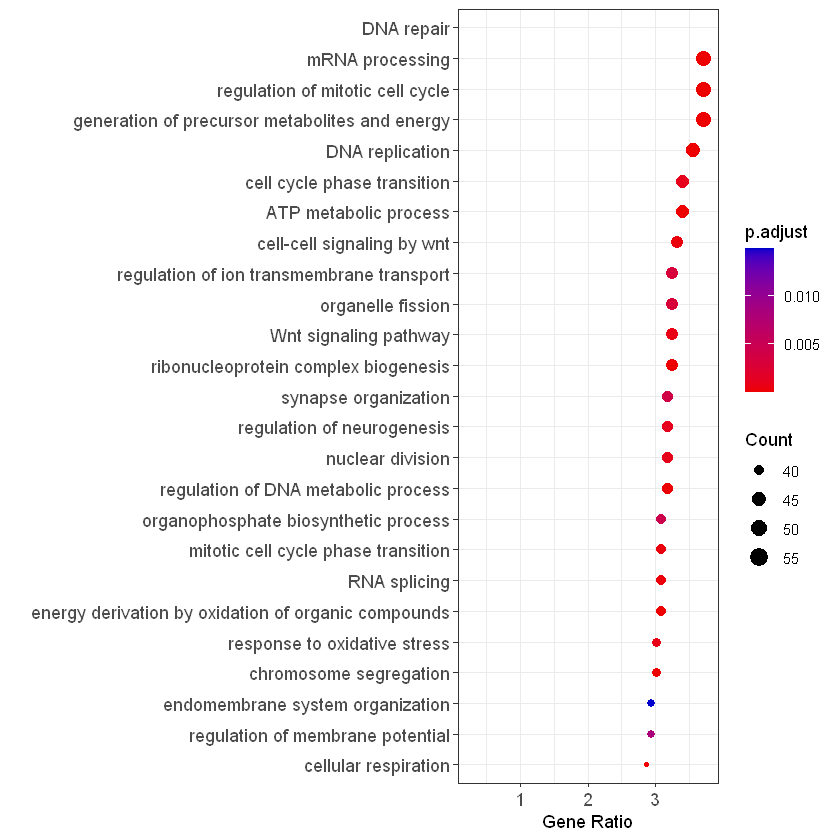

In [29]:
# draw the dotplot, custermize
S1 <- data %>%
    arrange(Per) %>%
    mutate(Term = factor(Term, levels = Term)) %>%
    ggplot(aes(x = Per, y = Term)) + geom_point(aes(size = Count, color = p.adjust)) +
    scale_size(range = c(1, 5)) + xlim(0.25, 3.75) + labs(x = "Gene Ratio", y = "") +
    theme_bw() + theme(axis.text = element_text(size = 11))
S1 <- S1 + scale_color_gradient(low = "red2", high = "mediumblue", space = "Lab")
S1

In [ ]:
# save the figure to png, specify the dpi and size of the pic
ggsave(filename = "1.png", width = 7.5, height = 6, units = "in", dpi = 600)

## GOplot

In [6]:
# cluster plot with GOplot package
data(EC)
head(EC$genelist)
head(EC$david)
# inspect the structure of the data in GOplot data

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Slco1a4,6.645388,1.2168670,88.65515,1.32e-18,2.73e-14,29.02715
2,Slc19a3,6.281525,1.1600468,69.95094,2.41e-17,2.49e-13,27.62917
3,Ddc,4.483338,0.8365231,65.57836,5.31e-17,3.65e-13,27.18476
4,Slco1c1,6.469384,1.3558865,59.87613,1.62e-16,8.34e-13,26.51242
5,Sema3c,5.515630,2.3252117,58.53141,2.14e-16,8.81e-13,26.33626
6,Slc38a3,4.761755,0.9218670,54.11559,5.58e-16,1.76e-12,25.70308


,Category,ID,Term,Genes,adj_pval
,<fct>,<fct>,<fct>,<fct>,<dbl>
1,BP,GO:0007507,heart development,"DLC1, NRP2, NRP1, EDN1, PDLIM3, GJA1, TTN, GJA5, ZIC3, TGFB2, CERKL, GATA6, COL4A3BP, GAB1, SEMA3C, MKL2, SLC22A5, MB, PTPRJ, RXRA, VANGL2, MYH6, TNNT2, HHEX, MURC, MIB1, FOXC2, FOXC1, ADAM19, MYL2, TCAP, EGLN1, SOX9, ITGB1, CHD7, HEXIM1, PKD2, NFATC4, PCSK5, ACTC1, TGFBR2, NF1, HSPG2, SMAD3, TBX1, TNNI3, CSRP3, FOXP1, KCNJ8, PLN, TSC2, ATP6V0A1, TGFBR3, HDAC9",0.000002170
2,BP,GO:0001944,vasculature development,"GNA13, ACVRL1, NRP1, PGF, IL18, LEPR, EDN1, GJA1, FOXO1, GJA5, TGFB2, WARS, CERKL, APOE, CXCR4, ANG, SEMA3C, NOS2, MKL2, FGF2, RAPGEF1, PTPRJ, RECK, EFNB2, VASH1, PNPLA6, THY1, MIB1, NUS1, FOXC2, FOXC1, CAV1, CDH2, MEIS1, WT1, CDH5, PTK2, FBXW8, CHD7, PLCD1, PLXND1, FIGF, PPAP2B, MAP2K1, TBX4, TGFBR2, NF1, TBX1, TNNI3, LAMA4, MEOX2, ECSCR, HBEGF, AMOT, TGFBR3, HDAC7",0.000010400
3,BP,GO:0001568,blood vessel development,"GNA13, ACVRL1, NRP1, PGF, IL18, LEPR, EDN1, GJA1, FOXO1, GJA5, TGFB2, WARS, CERKL, APOE, CXCR4, ANG, SEMA3C, NOS2, MKL2, FGF2, RAPGEF1, PTPRJ, RECK, VASH1, PNPLA6, THY1, MIB1, NUS1, FOXC2, FOXC1, CAV1, CDH2, MEIS1, WT1, CDH5, PTK2, FBXW8, CHD7, PLCD1, PLXND1, FIGF, PPAP2B, MAP2K1, TBX4, TGFBR2, NF1, TBX1, TNNI3, LAMA4, MEOX2, ECSCR, HBEGF, AMOT, TGFBR3, HDAC7",0.000007620
4,BP,GO:0048729,tissue morphogenesis,"DLC1, ENAH, NRP1, PGF, ZIC2, TGFB2, CD44, ILK, SEMA3C, RET, AR, RXRA, VANGL2, LEF1, TNNT2, HHEX, MIB1, NCOA3, FOXC2, FOXC1, TGFB1I1, WNT5A, COBL, BBS4, FGFR3, TNC, BMPR2, CTNND1, EGLN1, NR3C1, SOX9, TCF7L1, IGF1R, FOXQ1, MACF1, HOXA5, BCL2, PLXND1, CAR2, ACTC1, TBX4, SMAD3, FZD3, SHANK3, FZD6, HOXB4, FREM2, TSC2, ZIC5, TGFBR3, APAF1",0.000119000
5,BP,GO:0048514,blood vessel morphogenesis,"GNA13, CAV1, ACVRL1, NRP1, PGF, IL18, LEPR, EDN1, GJA1, CDH2, MEIS1, WT1, TGFB2, WARS, PTK2, CERKL, APOE, CXCR4, ANG, SEMA3C, PLCD1, NOS2, MKL2, PLXND1, FIGF, FGF2, PTPRJ, TGFBR2, TBX4, NF1, TBX1, TNNI3, PNPLA6, VASH1, THY1, NUS1, MEOX2, ECSCR, AMOT, HBEGF, FOXC2, FOXC1, HDAC7",0.000720000
6,BP,GO:0051336,regulation of hydrolase activity,"CAV1, XIAP, AGFG1, ADORA2A, TNNC1, TBC1D9, LEPR, ABHD5, EDN1, ASAP2, ASAP3, SMAP1, TBC1D12, ANG, TBC1D14, MTCH1, TBC1D13, TBC1D4, TBC1D30, DHCR24, HIP1, VAV3, NOS1, NF1, MYH6, RICTOR, TBC1D22A, THY1, PLCE1, RNF7, NDEL1, CHML, IFT57, ACAP2, TSC2, ERN1, APAF1, ARAP3, ARAP2, ARAP1, HTR2A, F2R",0.001171166


In [7]:
# save the GO analysis data from clusterProfiler
# saved the data as stutured as the GOPlot data
david <- read.csv("./go_david.csv", stringsAsFactors = TRUE)
head(david)
# select the top 10 term for the cluster plot

,Category,ID,Term,Genes,adj_pval,Count
,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>
1,MF,GO:0048018,receptor ligand activity,"Adm, Areg, Bmp4, Bmp7, Bmp8a, Cck, Cer1, Cntf, Csf1, Lefty1, Fbn1, Fgf3, Fgf5, Vegfd, Flt3l, Ghrh, Il11, Il7, Ucn2, Mdk, Nppb, Pomc, Ccl2, Ccl6, Cxcl5, Sema3a, Sema3e, Slit2, Sst, Stc1, Stc2, Tac1, Efemp1, Ucn, Wnt2, Wnt2b, Wnt4, Wnt6, Gdf15, Tnfsf13b, Insl6, Tnfsf15, Pdgfc, Cxcl14, Sectm1b, Fgf22, C1qtnf4, Nmb, Cmtm8, Metrn, Wnt16, Hmgb2",1.18e-03,52
2,MF,GO:0140097,"catalytic activity, acting on DNA","Fancm, Dffb, Dnmt3b, Hells, Lig1, Mcm3, Mcm2, Mcm4, Mcm5, Mcm6, Pcna, Pola1, Pold1, Pole, Ptbp1, Rad51, Rad51b, Rad54l, Pif1, Gen1, Chtf18, Top2a, Ung, Neil3, Ercc6l, Atad5, Brip1, Exo1, Polk, Dna2, Isg20, Rad54b, Mcm8, Dnase1l1, Mutyh, Zgrf1, Mus81, Aplf, Dscc1, Rfc5, Setmar, Meiob, Polq",7.09e-10,43
3,MF,GO:0005201,extracellular matrix structural constituent,"Mmrn2, Npnt, Prelp, Bgn, Col12a1, Col13a1, Col14a1, Col3a1, Col4a4, Col5a1, Col7a1, Col8a1, Col9a2, Col1a1, Col1a2, Dmbt1, Fbln1, Fbn1, Fbn2, Lama1, Lama2, Papln, Mfap2, Matn4, Nid2, Slit2, Efemp1, Thbs1, Tnc, Impg2, Lamc1, Col23a1, Fbln5, Col6a6, Postn, Dpt, Hmcn2, Col6a4",2.52e-12,38
4,MF,GO:0015631,tubulin binding,"Kifc1, Nusap1, Kif24, Birc5, Brca2, Capn6, Dcx, Gli1, Kif11, Kif4, Kifc2, Mlph, Plk1, Kif20a, Kif15, Dlgap5, Kif18a, Cenpe, Prc1, Kif20b, Racgap1, Casc1, Kif14, Whamm, Rgs14, Knstrn, Spag5, Ska1, Spc24, Kif18b, D7Ertd443e, Kif23, Fam83d, Tpx2, Haus7, Kif2c, Traf3ip1",3.22e-02,37
5,MF,GO:0008017,microtubule binding,"Kifc1, Nusap1, Kif24, Birc5, Capn6, Dcx, Gli1, Kif11, Kif4, Kifc2, Mlph, Plk1, Kif20a, Kif15, Dlgap5, Kif18a, Cenpe, Prc1, Kif20b, Racgap1, Casc1, Kif14, Whamm, Rgs14, Knstrn, Spag5, Ska1, Spc24, Kif18b, D7Ertd443e, Kif23, Fam83d, Tpx2, Haus7, Kif2c, Traf3ip1",1.21e-04,36
6,MF,GO:0050839,cell adhesion molecule binding,"Isg15, Npnt, Casr, Cd1d1, Cdh1, Cdh15, Cdh17, Cdh6, Col3a1, Fbln1, Fbn1, Gfap, Ilk, Itga4, Itgb1bp1, Ctnnd2, Prom1, Thbs1, Vcam1, Dchs1, Gldn, Fbln5, Cdh24, Nlgn3, Slc14a2, Adgrl1, Tbc1d2, Postn, Ccdc141, Ptprh, Mypn, Cd177, Igsf9",8.41e-03,33


In [8]:
# select the the gene list with the exprssion data
genelist <- read.csv("./genelist.csv", stringsAsFactors = TRUE)
head(genelist)

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Gm36317,4.250088,-3.574291,7.250326,2.57e-04,0.002720,0.7508369
2,A230052G05Rik,4.050368,-1.541811,8.733893,8.58e-05,0.001520,1.7597816
3,D730045A05Rik,3.660759,-2.753603,4.263479,4.55e-03,0.016000,-1.6003440
4,1700034P13Rik,3.607136,-2.580458,5.511667,1.20e-03,0.006680,-0.4276808
5,Gm27204,3.520386,-2.064929,10.348567,3.08e-05,0.000945,2.2957786
6,1700016L04Rik,3.107218,-2.680818,10.418413,2.96e-05,0.000934,2.1678207


In [9]:
# Generate the plotting object
circ <- circle_dat(david, genelist)
head(circ)

,category,ID,term,count,genes,logFC,adj_pval,zscore
,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,MF,GO:0048018,receptor ligand activity,52,ADM,-0.9118672,0.00118,0.5547002
2,MF,GO:0048018,receptor ligand activity,52,AREG,0.5167269,0.00118,0.5547002
3,MF,GO:0048018,receptor ligand activity,52,BMP4,-0.7133805,0.00118,0.5547002
4,MF,GO:0048018,receptor ligand activity,52,BMP7,-0.5416656,0.00118,0.5547002
5,MF,GO:0048018,receptor ligand activity,52,BMP8A,0.6786883,0.00118,0.5547002
6,MF,GO:0048018,receptor ligand activity,52,CCK,0.5324564,0.00118,0.5547002


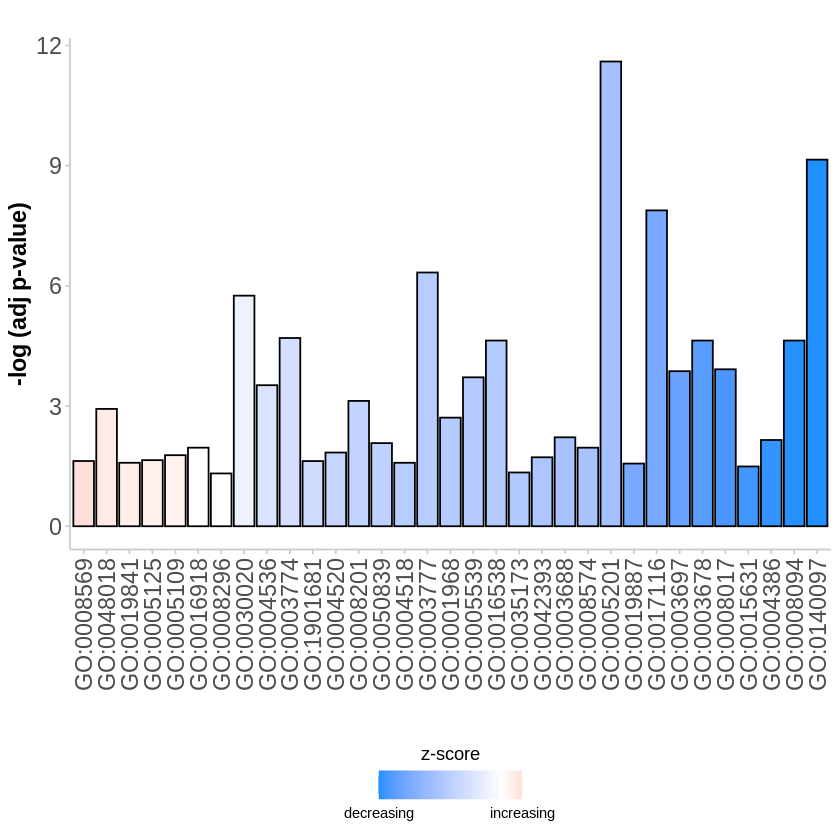

In [10]:
# Generate a simple barplot
GOBar(subset(circ, category == "MF"))

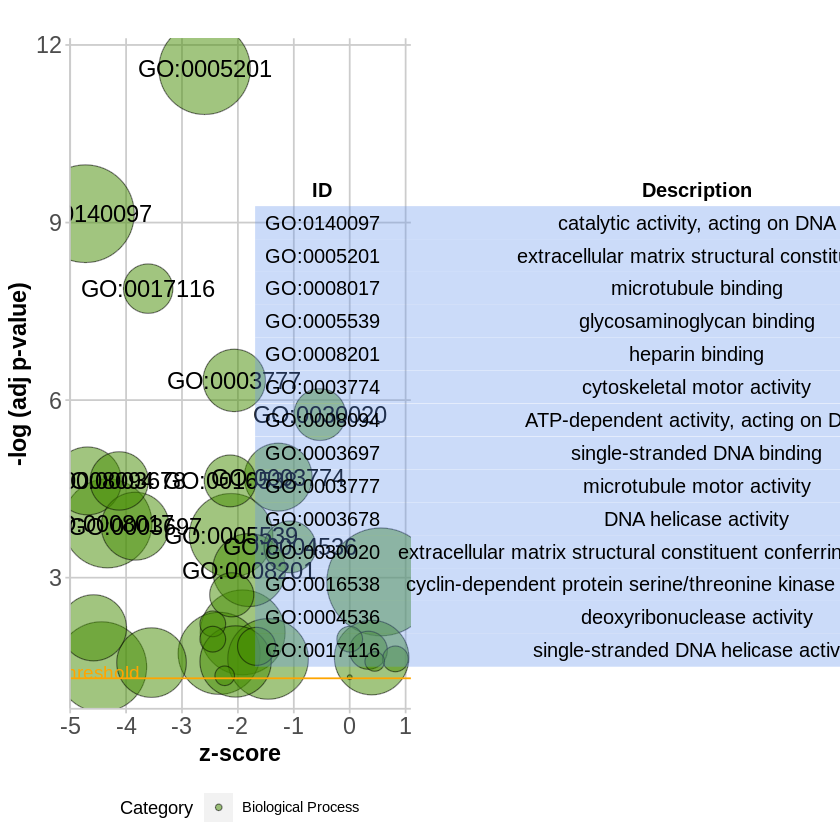

In [11]:
# Generate the bubble plot with a label threshold of 3
GOBubble(subset(circ, category == "MF"), labels = 3)

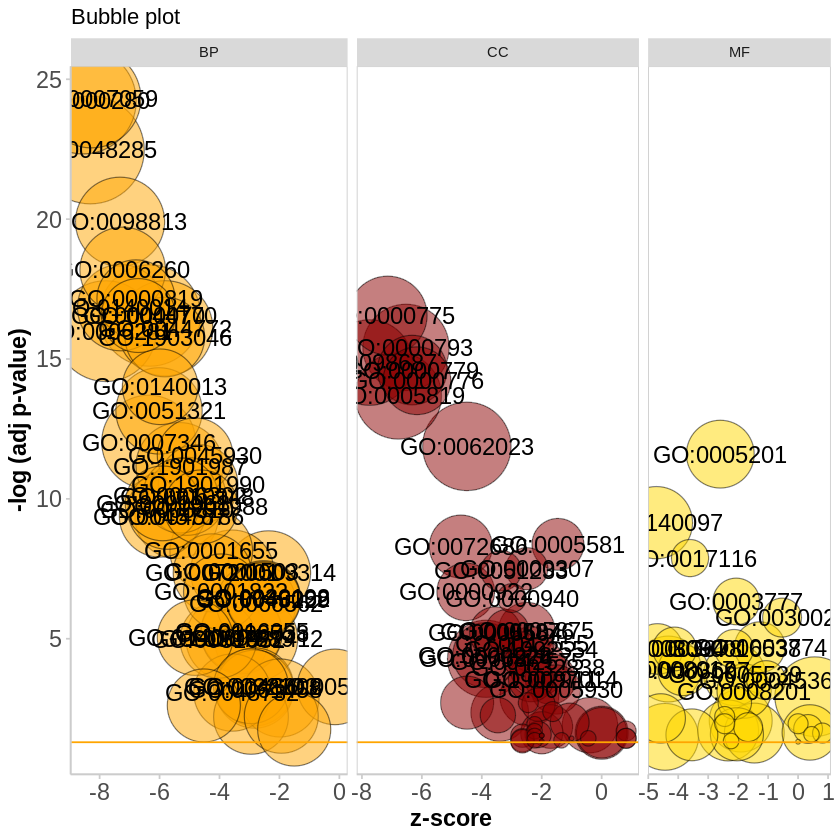

In [12]:
# Add a title, change the colour of the circles, facet the plot according to
# the categories and change the label threshold
GOBubble(circ, title = "Bubble plot", colour = c("orange", "darkred", "gold"), display = "multiple",
    labels = 3)

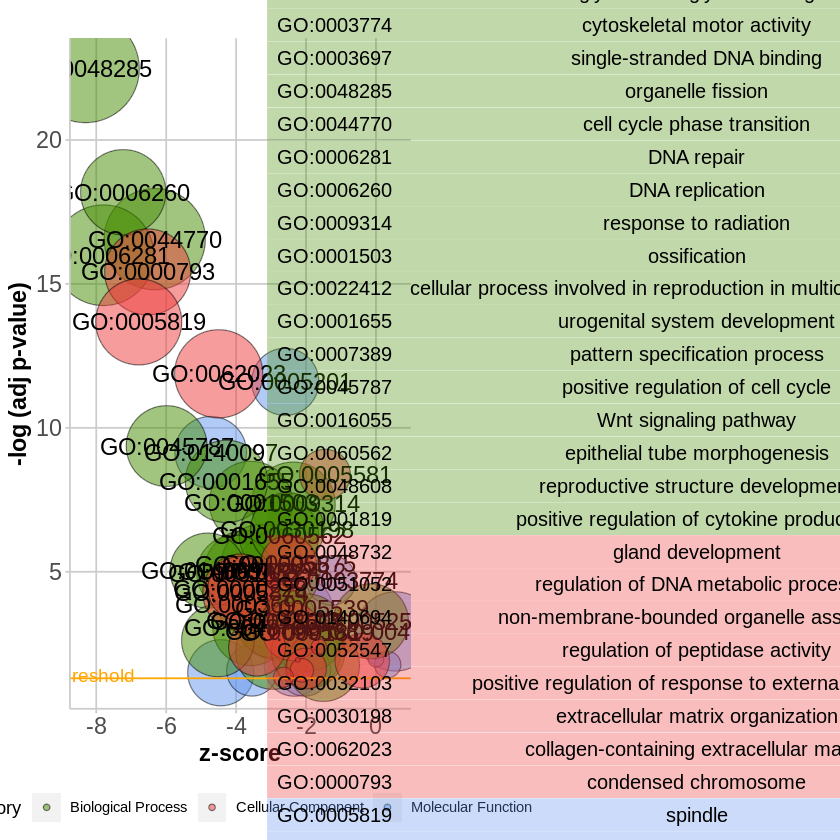

In [13]:
# Reduce redundant terms with a gene overlap >= 0.75...
reduced_circ <- reduce_overlap(circ, overlap = 0.75)
# ...and plot it
GOBubble(reduced_circ, labels = 2.8)

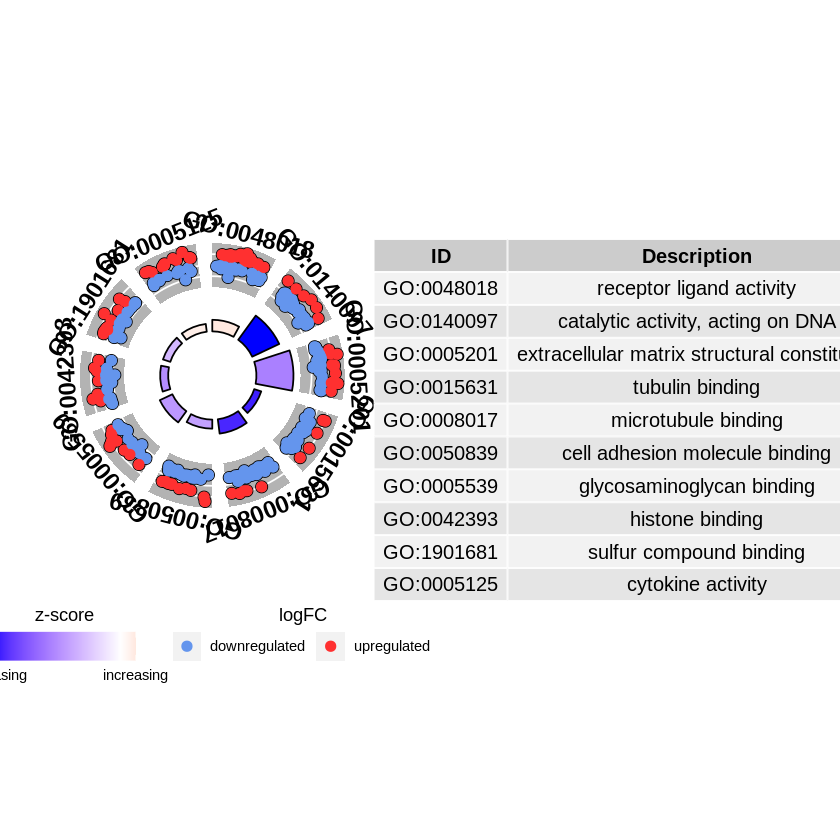

In [14]:
# Generate a circular visualization of the results of gene- annotation
# enrichment analysis
GOCircle(circ)

In [38]:
# select the genes appeared in the top 10 terms.
# genes <- unique(scan('./mf_genes.txt', what = 'character'))
genes <- unique(scan("./cc_genes.txt", what = "character"))
# get the unique gene list
length(genes)
genes

[1] 207

[1] "Mmrn2"    "Npnt"     "Prelp"    "Anxa3"    "Bgn"      "Bmp7"    
  [7] "Serpinh1" "Entpd2"   "Col12a1"  "Col13a1"  "Col14a1"  "Col3a1"  
 [13] "Col4a4"   "Col5a1"   "Col7a1"   "Col8a1"   "Col9a2"   "Col1a1"  
 [19] "Col1a2"   "Dmbt1"    "Cstb"     "Fbln1"    "Fbn1"     "Fbn2"    
 [25] "Gpc4"     "Itih2"    "Lama1"    "Lama2"    "Lox"      "Papln"   
 [31] "Mfap2"    "Matn4"    "Mmp9"     "Nid2"     "Serpine1" "Sfrp1"   
 [37] "Slit2"    "Sod3"     "Itih5"    "Efemp1"   "Thbs1"    "Tnc"     
 [43] "Trf"      "Wnt2"     "Impg2"    "Lamc1"    "Col23a1"  "Fbln5"   
 [49] "Frem2"    "Podnl1"   "Col6a6"   "Egflam"   "Ssc5d"    "Omd"     
 [55] "Frem1"    "Elane"    "Postn"    "Dpt"      "Hmcn2"    "Clec14a" 
 [61] "Ccdc80"   "Col6a4"   "F13a1"    "Loxl2"    "Cenpi"    "Mtbp"    
 [67] "Cenpf"    "Birc5"    "Brca1"    "Brca2"    "Bub1"     "Bub1b"   
 [73] "Cdk2"     "Cenpa"    "Chek1"    "Smc2"     "Hus1"     "Incenp"  
 [79] "Mki67"    "Nek2"     "Plk1"     "Psmc3ip"  "Rad51"    "Kntc1"   
 [85] "Aurkb"    "Hus1b"    "Fancd2"   "Ska3"     "Top2a"    "Ttk"     
 [91] "Ttn"      "Kif18a"   "Cenpe"    "Topbp1"   "Ercc6l"   "Ccnb1"   
 [97] "Cenph"    "Cenpt"    "Nsl1"     "Knstrn"   "Spag5"    "Ncapg"   
[103] "Dnmt3l"   "Mad2l1"   "Xlr3b"    "Cenpk"    "Cenpw"    "Spc25"   
[109] "Ska1"     "Cenpm"    "Nuf2"     "Pmf1"     "Ndc80"    "Spc24"   
[115] "Itgb3bp"  "Zwilch"   "Ncapd2"   "Spdl1"    "Syce2"    "Cenpu"   
[121] "Kif2c"    "Setmar"   "Mei4"     "Hormad2"  "Hmgb2"    "Kifc1"   
[127] "Espl1"    "Nusap1"   "Aspm"     "Camk2b"   "Capn6"    "Cdc25b"  
[133] "Cdk1"     "Ect2"     "Gem"      "Kif11"    "Kifc2"    "Kif20a"  
[139] "Plk4"     "Aurka"    "Tacc3"    "Dlgap5"   "Wdr62"    "Prc1"    
[145] "Cdc6"     "Kif20b"   "Klhl21"   "Racgap1"  "Ptpn7"    "Kif14"   
[151] "Rgs14"    "Cdca8"    "Fbxo5"    "Aunip"    "Kif18b"   "Poc1a"   
[157] "Ckap2l"   "Katnal2"  "Kif23"    "Fam83d"   "Mad2l2"   "Haus5"   
[163] "Tpx2"     "Cep89"    "Haus7"    "Bora"     "Misp"     "Dnmt3b"  
[169] "Ezh2"     "Hells"    "Orc1"     "Pold1"    "Rad51ap1" "Pif1"    
[175] "Mis18bp1" "Dna2"     "Cenpp"    "Oip5"     "Esco2"    "Dscc1"   
[181] "Dcdc2b"   "Kif24"    "Dnah5"    "Dcx"      "Kif4"     "Kif15"   
[187] "Tuba4a"   "Ttll8"    "Whamm"    "Tuba8"    "Iqgap2"   "Dcxr"    
[193] "Dnah17"   "Arhgap18" "Klc4"     "Mcm2"     "Pcna"     "Pola1"   
[199] "Pold2"    "Pole"     "Pole2"    "Prim1"    "Mms22l"   "Gins2"   
[205] "Zbtb32"   "Fignl1"   "Tipin"

In [28]:
# generat the genelist data with only the selected genes
genes_data <- genelist %>%
    filter(genelist$ID %in% genes) %>%
    select(ID, logFC)
genes_data <- genes_data %>%
    mutate(ID = str_to_upper(ID))
head(genes_data)

,ID,logFC
,<chr>,<dbl>
1,APOB,1.925939
2,JCHAIN,1.790641
3,4930486L24RIK,1.535560
4,SLC14A2,1.439549
5,GDF15,1.356440
6,DMBT1,1.354119


In [37]:
# select the top 10 process(term)
process <- read_csv("./process_cc.csv")$Process
process

Rows: 10 Columns: 1

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Process


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] "collagen-containing extracellular matrix"
 [2] "condensed chromosome"                    
 [3] "spindle"                                 
 [4] "chromosomal region"                      
 [5] "chromosome, centromeric region"          
 [6] "microtubule"                             
 [7] "condensed chromosome, centromeric region"
 [8] "kinetochore"                             
 [9] "nuclear chromosome"                      
[10] "mitotic spindle"

In [39]:
# now it is time to generate the binary matrix
chord <- chord_dat(data = circ, genes = genes_data, process = process)
dim(chord)

[1] 92 11

Warning message:
“Using size for a discrete variable is not advised.”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


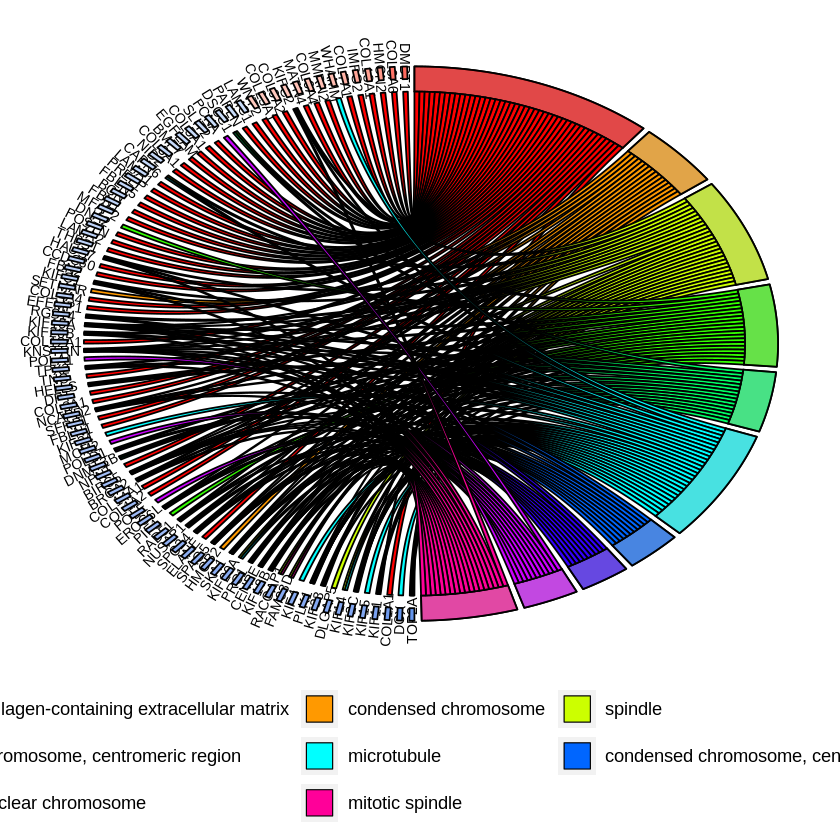

In [40]:
# chord plot, or the cohort plot
GOChord(chord, space = 0.02, gene.order = "logFC", gene.space = 0.1, gene.size = 3)

Warning message:
“Using size for a discrete variable is not advised.”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


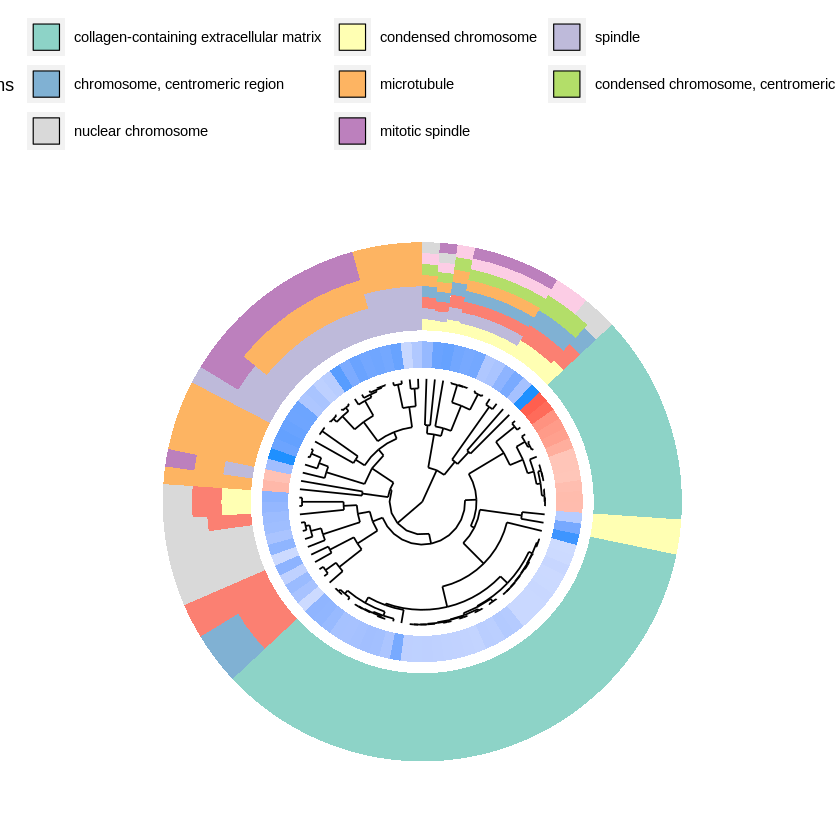

In [41]:
# cluster plot, set the space and witdth settings for terms and lfc, set the color
GOCluster(circ, process, clust.by = "term", term.width = 2, lfc.width = 0.5, term.space = 0.25,
    lfc.space = 0.25) + theme(legend.position = "top", legend.key.size = unit(0.5,
    "cm"))

Warning message:
“Using size for a discrete variable is not advised.”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


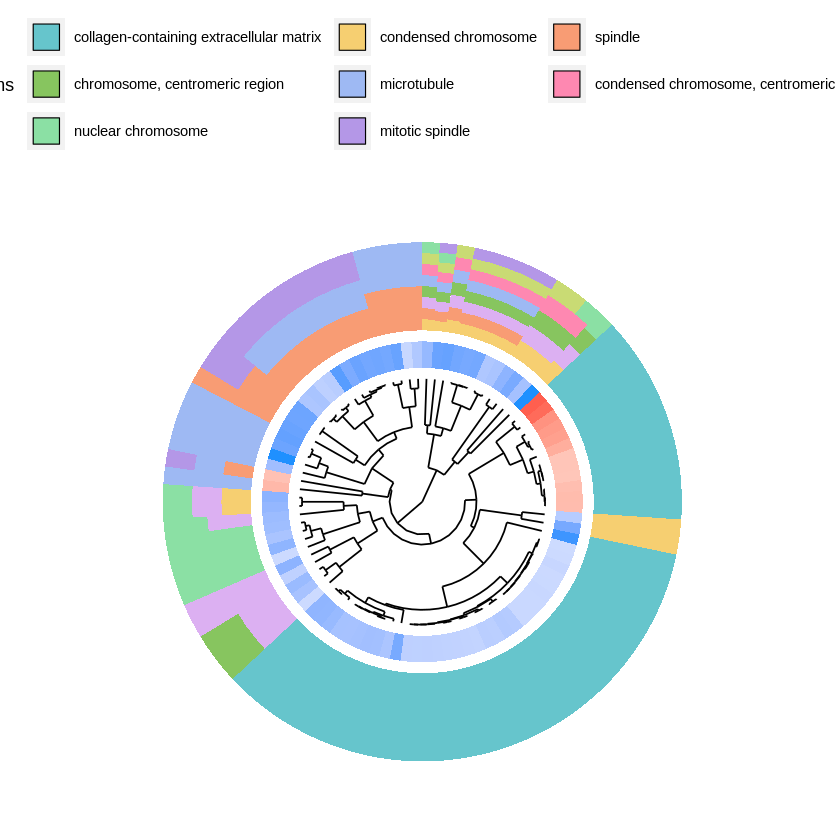

In [42]:
# cluster plot, set the space and witdth settings for terms and lfc, set the
# color
colors = c("#66C5CCFF", "#F6CF71FF", "#F89C74FF", "#DCB0F2FF", "#87C55FFF", "#9EB9F3FF",
    "#FE88B1FF", "#C9DB74FF", "#8BE0A4FF", "#B497E7FF")
GOCluster(circ, process, clust.by = "term", term.width = 2, lfc.width = 0.5, term.space = 0.25,
    lfc.space = 0.25, term.col = colors) + theme(legend.position = "top", legend.key.size = unit(0.5,
    "cm"))

In [36]:
ggsave(filename = "1.png", width = 12, height = 12, units = "in", dpi = 600)

Warning message:
“Using size for a discrete variable is not advised.”
Warning message:
“Removed 10 rows containing missing values (geom_point).”
